In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import os
from pyxtal_xrd.XRD import XRD
from ase.io import read
from pyxtal_xrd.database.element import Element
from pyxtal_xrd.similarity import Similarity
from pyxtal_xrd.profile import Profile

/Users/sayred1/anaconda3/lib/python3.7/site-packages/numba/decorators.py:220: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


#### The first job for the user is provide a crystallographic file that describes some crystal structure. Call the crystal module to create the structure.
- **Necessary conditions**:
    1. The file must be either **.cif** or **POSCAR** file
    2. If a cif file, the structure must either have **no occupancy**, full and partial occupancy are not yet suppored by XRD.
    
- We use ase to read structures

ex: read(crystal_file, format = 'vasp')

In [8]:
# loading a structure via -POSCAR file
crystal = './dataset/NaCl-POSCAR'
structure = read(crystal, format = 'vasp') 

# loading a structure via .cif file
crystal = './dataset/NaCl.cif'
structure = read(crystal, format = 'cif') 

#### After computing the structure, the user can call XRD to obtain the XRD pattern.
- Three parameters must be specified:
    1. the structure, obtained above  (XRD.crystal)
    2. the wavelength of the xray source (in Angstroms) (float)
    3. the range of measurement angle (list) ex [0,180]
- The user could also specify whether or not they want to include preferred orientation (boolean)
    - If True, user will specify some float, between 0 and 1, for the calculation of PO
    - For now, it's best if don't include this into the website.
    
ex: XRD(structure, 1.54056, [0,180])

#### All XRD results are grouped by their equivalent hkl planes in the pxrdf method, and accessed by calling the XRD.pxrd method.
- In order, the results are (N*6) arrays, where N corresponds to a single plane and 6 corresponds to:
    1. angle
    2. d_hkl
    3. h
    4. k
    5. l
    6. intensity

In [10]:
xrd1 = XRD(structure, 1.54056, [0,120]) 
theta2 = xrd1.pxrd[:,0]
intensity = xrd1.pxrd[:,-1]

#### Next, the user can apply a profiling function to their simulated XRD pattern. 
- When calling the Profile class, the user must specify 3 arguments and keyword arguments 
    1. method (str)
    2. res (float) 
    3. user_kwargs (dict)
    

- user_kwargs are available for users to specify parameters used for profiling 

#### Profiling can then be done by calling the get_profile method
- This method requires 4 arguments:
    1. two_thetas (1-D Arr) - from XRD simulation
    2. intensities (1-D Arr) - from XRD simulation
    3. min2theta (float)
    4. max2theta (float)
    
- There are currently 3 profiling methods the user can choose from
    1. gaussian (theta indep)
    2. lorentzian (theta indep)
    3. pseudo_voigt (theta dep)
- in the first two methods the user can choose from, the FWHM is defined by the user and is theta-independent, the other is theta dependent and the user must specify several parameters.
- The number of points (N) within the profiling array depends on 2, 3, and f: N = int(max2theta-min2theta)/res.

##### Gaussian. 

In [11]:
user_kwargsG = {'FWHM': 0.05}
profile = Profile(method = 'gaussian', res = 0.01, user_kwargs = user_kwargsG)
profile.get_profile(two_thetas = theta2, intensities = intensity, min2theta = 0, max2theta = 120)

array([[0.00000000e+000, 1.00008334e-002, 2.00016668e-002, ...,
        1.19979998e+002, 1.19989999e+002, 1.20000000e+002],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.94769795e-148, 8.31342099e-154, 2.84244641e-159]])

##### Lorentzian
- similar to the gaussian howver, simply change the method

In [12]:
user_kwargsL = {'FWHM': 0.05}
profile = Profile(method = 'lorentzian', res = 0.01, user_kwargs = user_kwargsL)
profile.get_profile(two_thetas = theta2, intensities = intensity, min2theta = 0, max2theta = 120)

array([[0.00000000e+00, 1.00008334e-02, 2.00016668e-02, ...,
        1.19979998e+02, 1.19989999e+02, 1.20000000e+02],
       [1.10287321e-06, 1.10346781e-06, 1.10406293e-06, ...,
        3.70898185e-04, 3.57930133e-04, 3.45633956e-04]])

##### Pseudo-voigt

In [13]:
U = 5.776410E-03 # FWHM parameter, U
V = -1.673830E-03 # FWHM parameter, V
W = 5.668770E-03 # FWHM parameter, W
A = 1.03944 # Asymmetry parameter, a1
eta_h = 0.504656 # Mixing parameter, eta_H0
eta_l = 0.611844  # Mixing parameter, eta_L0

# Theta-dependent profiling
user_kwargsPV = {'U': U, 'V':V, 'W':W, 'A':A, 'eta_h':eta_h, 'eta_l':eta_l}
profile = Profile(method = 'pseudo_voigt', res = 0.01, user_kwargs = user_kwargsPV)
profile.get_profile(two_thetas = theta2, intensities = intensity, min2theta = 0, max2theta = 120)

array([[0.00000000e+00, 1.00008334e-02, 2.00016668e-02, ...,
        1.19979998e+02, 1.19989999e+02, 1.20000000e+02],
       [1.39424459e-06, 1.39498035e-06, 1.39571673e-06, ...,
        6.68146193e-04, 5.98195610e-04, 6.23184558e-04]])

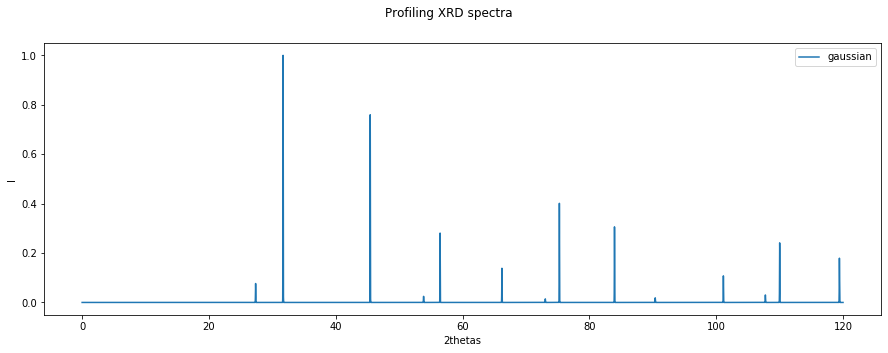

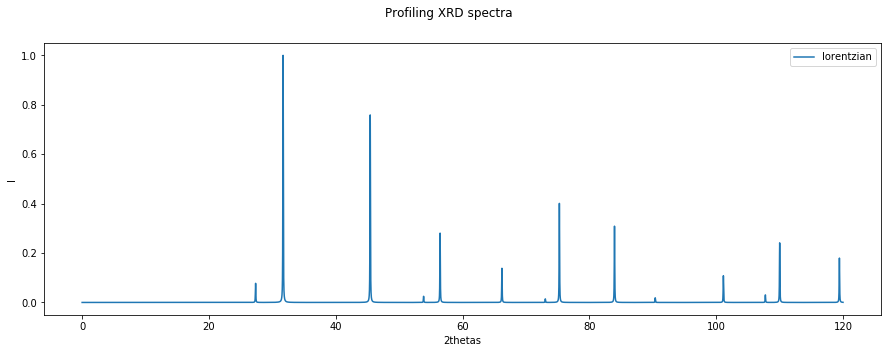

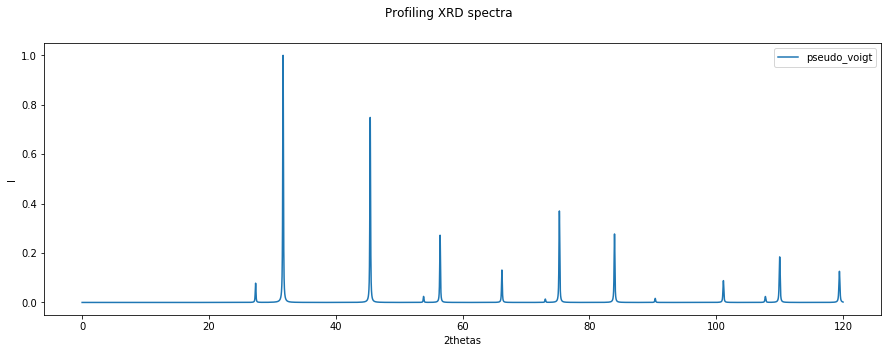

In [14]:
kwargs =  [user_kwargsG,user_kwargsL,user_kwargsPV]
methods = ['gaussian', 'lorentzian', 'pseudo_voigt']
# now you can choose from a list of different profiling functions, and plot them

for kwarg,method in zip(kwargs,methods):
    plt.figure(figsize=(15,5))
    plt.suptitle('Profiling XRD spectra')
    plt.xlabel('2thetas')
    plt.ylabel('I')
    profile = Profile(method = method, res = 0.01, user_kwargs = kwarg)
    profile.get_profile(two_thetas = theta2, intensities = intensity, min2theta = 0, max2theta = 120)
    spectra = profile.spectra
    theta2 = spectra[0]
    intensity = spectra[1]
    plt.plot(theta2,intensity,label=method)
    plt.legend()
    plt.show()
